<a href="https://colab.research.google.com/github/kjspring/stress-detection-wearable-devices/blob/main/notebooks/WESAD_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Stress From Wearable Devices
- Author: Kevin Spring
- Blog post: https://medium.com/@kevinjspring/stressful-conditions-6e6fc5eb018a

# Summary
We are HealthOn, a wearable device manufacturer focused on improving the health of our users. Our devices measures many physiological data in real time.

We are building a machine learning model to forecast stress within the next 5 minutes period of a HealthOn user. Using publically available data from the WESAD dataset, we determine the feasability of forecasting stress. The best models are only slightly better than guessing the stress or normal state of a user. More data needs to be collected on a variety of subjects under stressful conditions to improve the models.

We recommend:
1. Enhance Feature Measurement: In order to improve the accuracy of stress forecasting, it is recommended to focus on measuring physiological features that have a high causality with stress. Specifically, consider incorporating measurements such as respiration rate, heart rate variability, body temperature, and electrodermal activity. These features have been found to be closely linked to stress responses and can provide valuable insights for stress prediction models. 

2. Expand Data Collection: To further improve the forecasting models, it is crucial to gather a more diverse and comprehensive dataset. Collecting data from a larger sample size of individuals, particularly in both stressful and normal conditions, will allow for a better understanding of the variations and patterns associated with stress. Encourage voluntary data collection from users, ensuring privacy and consent, to increase the dataset's size and diversity.

3. Focus on Stressful Conditions: To specifically address stress forecasting, it is important to prioritize data collection during high-stress situations or events. This can be achieved by designing studies or collecting data from individuals undergoing stressful experiences, such as work-related stress, performance anxiety, or challenging life events. This targeted data collection will help train the models to better identify and predict stress states accurately.

4. Continuous Model Improvement: As stress forecasting is a complex task, it is essential to continuously refine and enhance the machine learning models. Regularly analyze the performance of the models, identify areas for improvement, and iterate on the algorithms and techniques used. As more data becomes available and the models evolve, periodically reassess their performance and implement necessary updates.

## Table of Contents

## Introduction

HealthOn is focused on improving the health of users through the development of wearable device technology. We currently have a range of smartwatches that collect heart rate, steps taken, and activity level. We are designing our next generation of smartwaches and want to identify which features to include that will take health monitoring to a new level.

### Stress
Stress can have detrimental effects on both mental and physical health. When individuals experience prolonged or chronic stress, it can contribute to various mental health disorders such as anxiety, depression, and burnout. Additionally, stress can become physical symptoms and lead to conditions such as cardiovascular diseases, gastrointestinal problems, weakened immune system, and impaired cognitive functioning. Furthermore, chronic stress can exacerbate existing health conditions and hinder the recovery process.

Also, the cost of stress on the American economy is staggering. It is estimated that workplace stress alone costs the US economy billions of dollars annually in terms of healthcare expenses, absenteeism, reduced productivity, and employee turnover. Additionally, stress-related issues contribute to increased healthcare costs, decreased job satisfaction, and lower overall economic growth.

Stress is a prevalent issue in society, and a significant portion of the population experiences stressful events each year. A substantial portion of the population encounters stressful events within a given year. These events can range from work-related stress, financial pressures, relationship difficulties, health concerns, and other life challenges.

Recognizing the significant economic costs, high prevalence, and negative impacts on individuals, it is crucial to prioritize stress management and promote strategies that reduce stress levels.

## Business Problem

HealthOn is focused on improving the health of users through the development of wearable devices. The goal is to collect and analyze physiological data in real time to provide insights and interventions to improve users health. 

Stress is a significant health related burden for individuals. It can lead to mental and somatic health issues. Changes in the body are correlated when a person is going into a stressful situation, for example, they will sweat more and their heart rate will increase.

We want to forecast if a user will be in a stressful state in the immediate future. Our device will then notify the user with recommendations to mitigate the stess.

### Project Objective

This project aims to assess the feasability of using physiological data to forecast a subject going into stress. It also aims to identify the most import features in detecting stress for the aim of improving wearable device development and design.

## Stakeholders
- Project Manager
- Business executives

# Data

## Data Source
The [WESAD dataset](https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29) is a publicly available dataset designed for wearable stress and affect detection. It was collected during a lab study and includes physiological and motion data from 15 subjects. The data was recorded using two devices: a chest-worn device called RespiBAN and a wrist-worn device called Empatica E4.

The RespiBAN device provides data on various sensors, including electrocardiogram (ECG), electrodermal activity (EDA), electromyogram (EMG), respiration, body temperature, and three-axis acceleration. All signals from this device are sampled at a rate of 700 Hz.

The Empatica E4 device captures data from sensors such as blood volume pulse (BVP), electrodermal activity (EDA), body temperature, and three-axis acceleration. The sampling rates for these signals are 64 Hz, 4 Hz, 4 Hz, and 32 Hz, respectively.

The dataset contains three affective states: neutral, stress, and amusement, but neutral and ameusment were recaracherized as the same nonstress case (case 0). The neutral state serves as a baseline condition where subjects were engaged in standing or sitting while reading magazines. The amusement condition involves subjects watching a set of eleven funny video clips. The stress condition involves subjects participating in the Trier Social Stress Test (TSST), which includes public speaking and mental arithmetic.

Additionally, the dataset includes self-reports of the subjects obtained using established questionnaires, providing additional information about their experiences and perceptions.

For further details about the dataset structure, data format, study protocol, and self-report questionnaires, you can refer to the dataset's readme-file or the provided source [1].

[1] WESAD (Wearable Stress and Affect Detection) Dataset. Available online: https://archive.ics.uci.edu/ml/datasets/WESAD+%28Wearable+Stress+and+Affect+Detection%29

### Download instructions
The raw data can be downloaded as a [zip file (2.1 GB)](https://drive.google.com/file/d/1q0WNZGxjuCOfEXhBeZcBbBtno8GI_sYA/view?usp=share_link) or available in a [Google Drive directory](https://drive.google.com/drive/folders/1zP2L7zcTDCgQDjtQbk7VugXGz_o7HGu8?usp=share_link). After downloading the files store them in a top-level Google Drive directory as stress-prediction or modify the code below to reflect your working directory.

In [1]:
# Import the necessary packages

import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import pickle

# install neurokit2 for signal processing
! pip install neurokit2
import neurokit2 as nk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.1 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# View files in the directory stress-prediction
! ls /content/drive/MyDrive/stress-prediction

cvxEDA.py  data_wrangling.py  img      logs    __pycache__
data	   files	      img.png  models  WESAD


In [4]:
# set path for data directory
os.chdir('/content/drive/MyDrive/stress-prediction')

# absolute path of data directory
PATH = os.path.join(os.path.abspath(os.getcwd()), 'data') # Path of data folder on Google Drive

## Open and clean up raw data
The data for swell and wsead is stored in seperate folders. Within each of these is a subfolder holding the eda, rri, and Labels folders

In [5]:
original_dir = os.path.join(PATH, 'original')
org_WESAD_dir = os.path.join(original_dir, 'WESAD')
print(org_WESAD_dir)

/content/drive/MyDrive/stress-prediction/data/original/WESAD


In [6]:
class SubjectData:
    
    '''
    This code defines a class called `SubjectData` that stores raw data from 
    the WESAD dataset and provides helper functions to extract wrist or 
    chest data.
    Modified from https://github.com/WJMatthew/WESAD/blob/master/data_wrangling.py

    Attributes:
    - `name`: Subject name.
    - `subject_keys`: Keys for subject data.
    - `signal_keys`: Keys for signal data.
    - `chest_keys`: Keys for chest data.
    - `wrist_keys`: Keys for wrist data.

    Methods:
    - `__init__(self, main_path, subject_number)`: Initializes the object with 
       the main path and subject number. Loads the raw data from the WESAD 
       dataset and sets the labels accordingly.
    - `get_wrist_data(self)`: Retrieves the wrist data from the loaded data, 
       adds additional features, and includes the labels. Returns the updated data.
    - `get_chest_data(self)`: Retrieves the chest data from the loaded data 
       and returns it.
    '''
    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']
        # Set labels > or < 2 as non-stress (case 0)
        self.labels[self.labels < 2] = 0
        self.labels[self.labels > 2] = 0
        # Set labels == 2 as stress state (case 1)
        self.labels[self.labels == 2] = 1

    def get_data(self):
        data = self.data['signal']['chest']
        # Modified to extract chest ECG data too
        data.update({'ECG': self.data['signal']['chest']['ECG']})
        data.update({'EMG': self.data['signal']['chest']['EMG']})
        data.update({'HRV': self.data['signal']['wrist']['BVP']})
        data['labels'] = self.labels
        return data

    def get_chest_data(self):
        return self.data['signal']['chest']

In [7]:
def subject_data_import(directory):
  '''
  WESAD raw data is stored in a pkl file of each specific subject.
  This function scans through the directories and imports the pkl files.
  It then calls the SubjectData object and stores the subject dictionaries.
  '''
  import regex as re

  regex = re.compile(r'\d+')
  subject_li = []
  ext = '.pkl' # pickle extension
  # Walk through data directory and only return with specific extension
  for path, dirc, files in os.walk(directory):
    for name in files:
      if name.endswith(ext):
        # Extract the subject number
        subject_number = regex.findall(name) 

        # Create SubjectData object
        subject_li.append(SubjectData(directory, int(subject_number[0]))) 
        
  return subject_li

In [8]:
# Store all subject data into a list of SubjectData objects
# Each SubjectData object represents a single subject
wesad_sd_li = subject_data_import(org_WESAD_dir)

## Feature Extraction

NeuroKit2 is a Python library designed for the analysis and processing of physiological data, specifically focusing on electrocardiography (ECG), electrodermal activity (EDA), electromyography (EMG), and other biosignals. It provides a wide range of functionalities to clean, process, and analyze physiological data efficiently.

The main purpose of NeuroKit2 is to simplify the analysis pipeline for researchers and practitioners working with physiological data. It offers a high-level interface that abstracts complex operations and algorithms, allowing users to focus on their research questions rather than the technical details of signal processing.

One of the key features of NeuroKit2 is its ability to perform comprehensive cleaning and preprocessing of physiological data. It includes functionalities for handling artifacts and noise, detecting and correcting anomalies, filtering signals, and normalizing data. These preprocessing steps are crucial to ensure the quality and reliability of the physiological data before further analysis.

In [9]:
# Extract data and store in a list
# Will create a list of dictionaries for each subject
wesad_data_li = [ f.get_data() for f in wesad_sd_li ]

In [10]:
wesad_data_li[0].keys()

dict_keys(['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp', 'HRV', 'labels'])

In [11]:
# Perform automated processing of bio signals using NeuroKit2
# bio_process() is a wrapper function for processing ECG, RSP, EDA, EMG, and other bio signals
# It automatically processes the provided bio signals and extracts relevant features

# Call the bio_process() function with the respective bio signals and sampling rate
processed_data, info = nk.bio_process(eda=wesad_data_li[0]['EDA'].reshape(-1),
                                      rsp=wesad_data_li[0]['Resp'].reshape(-1),
                                      ecg=wesad_data_li[0]['ECG'].reshape(-1),
                                      sampling_rate=700)

# The processed_data variable contains the processed bio features such as 
# cleaned signals, heart rate, R peaks, etc.
# The info variable contains a dictionary with additional information about 
# the processed signals
# Both variables can be used for further analysis or visualization

In [12]:
# Add temperature to the processed_data dataframe
# This is added after because temperature is not processed with the other
# physiological signals
processed_data['TEMP'] = wesad_data_li[0]['Temp']

### Exploratory Data Analysis

In [13]:
# Data size
print(len(wesad_data_li[0]['EDA']))

# Drop rows that all data is Nan
processed_data.dropna(how='all', inplace=True)
len(processed_data)

3847200


3847200

In [14]:
# Inspect processed data dataframe
processed_data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 44 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   ECG_Raw                           3847200 non-null  float64
 1   ECG_Clean                         3847200 non-null  float64
 2   ECG_Rate                          3847200 non-null  float64
 3   ECG_Quality                       3847200 non-null  float64
 4   ECG_R_Peaks                       3847200 non-null  int64  
 5   ECG_P_Peaks                       3847200 non-null  int64  
 6   ECG_P_Onsets                      3847200 non-null  int64  
 7   ECG_P_Offsets                     3847200 non-null  int64  
 8   ECG_Q_Peaks                       3847200 non-null  int64  
 9   ECG_R_Onsets                      3847200 non-null  int64  
 10  ECG_R_Offsets                     3847200 non-null  int64  
 11  ECG_S_Peaks                       384

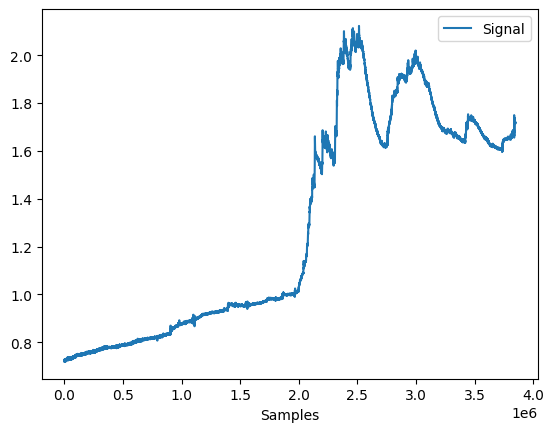

In [15]:
# inspect the cleaned EDA signal
nk.signal_plot(processed_data['EDA_Clean'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/eda_clean.pdf')

In [16]:
# What are the unique label IDs?
np.unique(wesad_data_li[0]['labels'])

array([0, 1], dtype=int32)

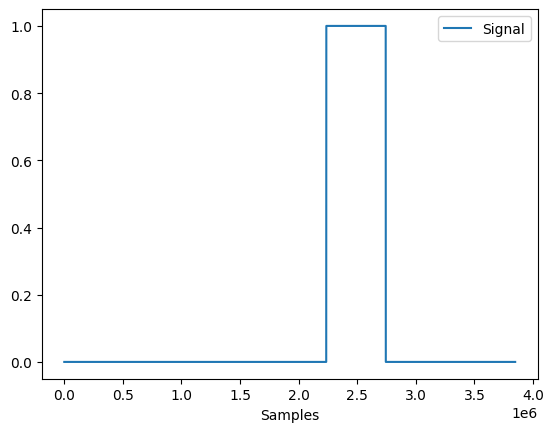

In [17]:
# Plot the signal
nk.signal_plot(wesad_data_li[0]['labels'])

array([[<Axes: title={'center': '0'}>]], dtype=object)

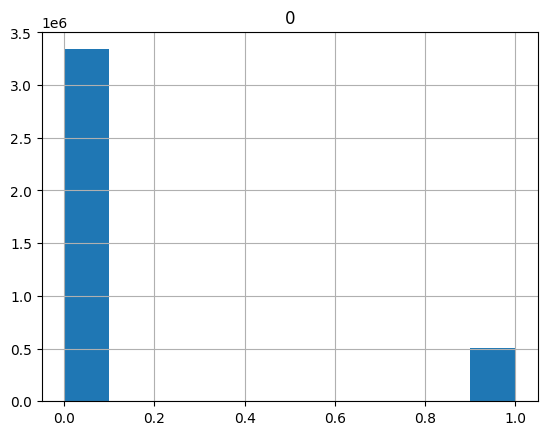

In [18]:
# Class labels are imbalanced
pd.DataFrame(wesad_data_li[0]['labels']).hist()

In [19]:
# Find events using the events_find() function from NeuroKit2
# Only on the first subject in exploration

'''
The event_channel parameter represents the channel containing the events
In this case, it is extracted from the 'labels' column of the `wesad_data_li` dataset
The function automatically detects and selects events based on specified parameters
These parameters include threshold, duration, onset time, etc., which can be adjusted as needed
The function returns a dictionary containing arrays of event onsets, durations, labels, and conditions (if specified)
The 'onset' array represents the onset times of the events
The 'duration' array represents the durations of the events
The 'label' array contains the event identifiers
The 'conditions' array contains optional information about the event conditions
The resulting 'events' dictionary can be used for further analysis or visualization
'''
# Call the events_find() function with the event channel from the `wesad_data_li` dataset
events = nk.events_find(event_channel=wesad_data_li[0]['labels'])

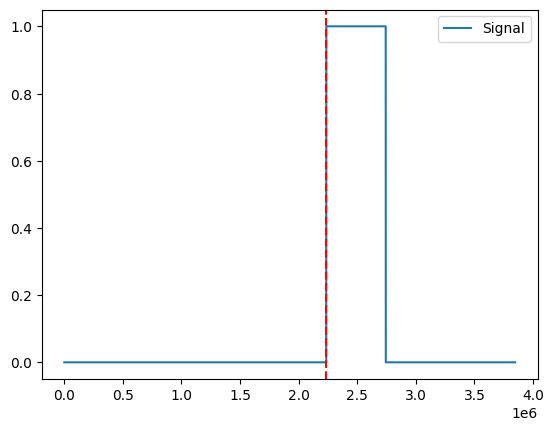

In [20]:
# Plot the event when stress is induced for the first subject
plot = nk.events_plot(events, wesad_data_li[0]['labels'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/signal_ex.pdf')

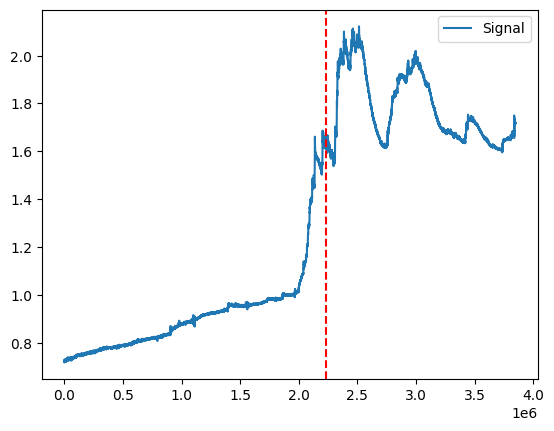

In [21]:
# Plot the signal event with the cleaned EDA signal
plot = nk.events_plot(events, processed_data['EDA_Clean'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/eda_w_signal.pdf')

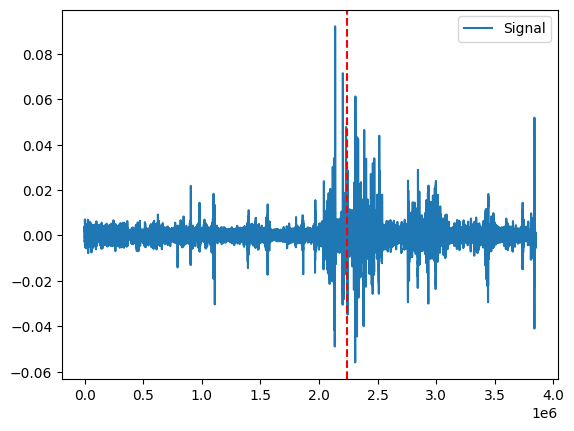

In [22]:
# Plot the signal event with the EDA Phase signal of the first subject
plot = nk.events_plot(events, processed_data['EDA_Phasic'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/eda_phase_signal.pdf')

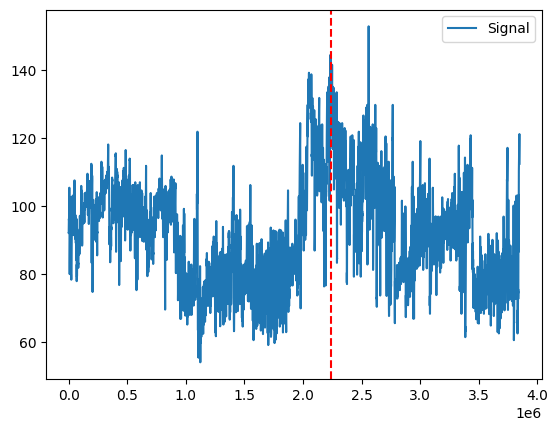

In [23]:
# Plot the signal event with the ECG rate signal of the first subject
nk.events_plot(events, processed_data['ECG_Rate'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/ECG_Rate_signal.pdf')

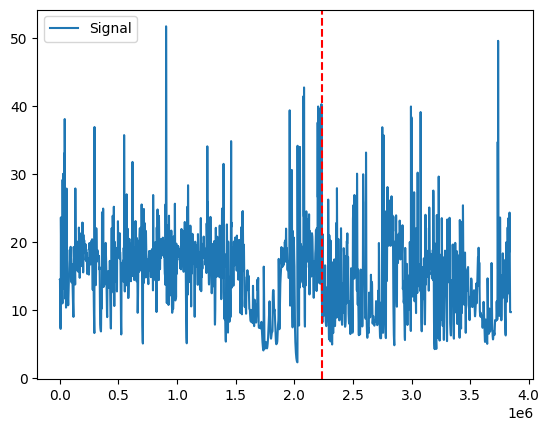

In [24]:
# Plot the signal event with the respiration rate of the first subject
nk.events_plot(events, processed_data['RSP_Rate'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/RSP_Rate_signal.pdf')

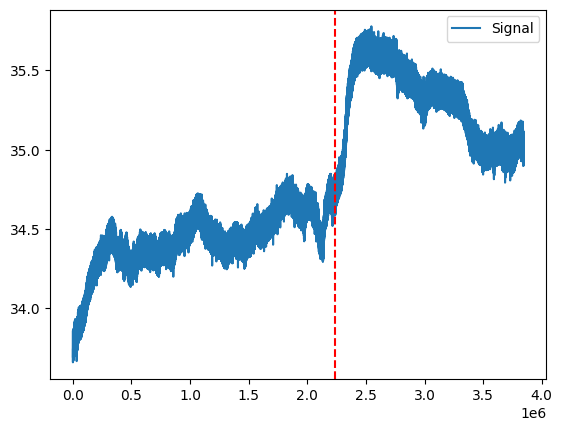

In [25]:
# Plot the signal event with the body temperature of the first subject
nk.events_plot(events, processed_data['TEMP'])
plt.savefig('/content/drive/MyDrive/stress-prediction/img/TEMP_signal.pdf')

In [26]:
# View all lbels in the processed_data
processed_data.keys()

Index(['ECG_Raw', 'ECG_Clean', 'ECG_Rate', 'ECG_Quality', 'ECG_R_Peaks',
       'ECG_P_Peaks', 'ECG_P_Onsets', 'ECG_P_Offsets', 'ECG_Q_Peaks',
       'ECG_R_Onsets', 'ECG_R_Offsets', 'ECG_S_Peaks', 'ECG_T_Peaks',
       'ECG_T_Onsets', 'ECG_T_Offsets', 'ECG_Phase_Atrial',
       'ECG_Phase_Completion_Atrial', 'ECG_Phase_Ventricular',
       'ECG_Phase_Completion_Ventricular', 'RSP_Raw', 'RSP_Clean',
       'RSP_Amplitude', 'RSP_Rate', 'RSP_RVT', 'RSP_Phase',
       'RSP_Phase_Completion', 'RSP_Symmetry_PeakTrough',
       'RSP_Symmetry_RiseDecay', 'RSP_Peaks', 'RSP_Troughs', 'EDA_Raw',
       'EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'SCR_Onsets', 'SCR_Peaks',
       'SCR_Height', 'SCR_Amplitude', 'SCR_RiseTime', 'SCR_Recovery',
       'SCR_RecoveryTime', 'RSA_P2T', 'RSA_Gates', 'TEMP'],
      dtype='object')

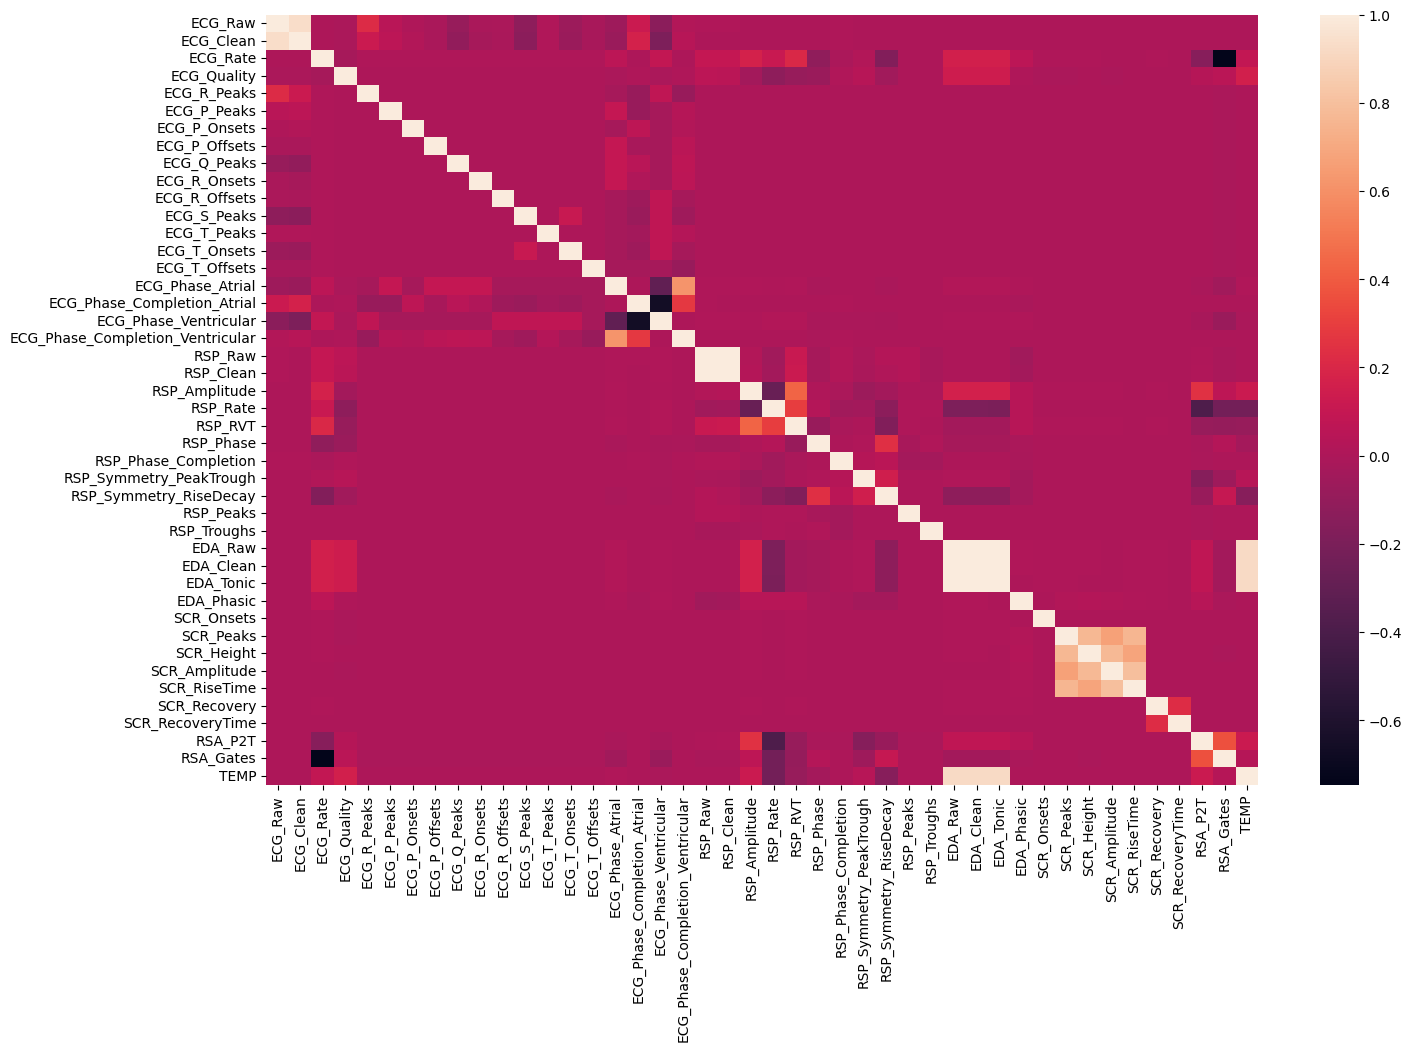

In [27]:
# Correlation Matrix of all features in the processed_data dataset
import matplotlib.pyplot as plt
import seaborn as sns

corr = processed_data.corr()
plt.figure(figsize=(16,10))
sns.heatmap(corr);

In [ ]:
# From the correlation matrix the following features look differentiable 
# and not highly correlated with each other

# RSP_Rate: Respiration rate 
# EDA_Phasic: The rapid/sudden changes in the EDA response
# ECG_Rate: Heart rate
# TEMP: body temperature
'''
processed_data_subset = processed_data[['RSP_Rate', 'EDA_Phasic', 'ECG_Rate', 'TEMP']]
processed_data_subset


,RSP_Rate,EDA_Phasic,ECG_Rate,TEMP
0,14.481092,-0.002589,91.999226,33.695862
1,14.481092,-0.002616,91.999226,33.741333
2,14.481092,-0.002641,91.999226,33.717072
3,14.481092,-0.002665,91.999226,33.741333
4,14.481092,-0.002688,91.999226,33.747406
...,...,...,...,...
3847195,9.690817,-0.000035,112.299465,35.015808
3847196,9.690817,-0.000032,112.299465,35.018921
3847197,9.690817,-0.000029,112.299465,35.020447
3847198,9.690817,-0.000027,112.299465,34.932495


In [28]:
def modeling_data_process(subject_data):
    """
    Process and prepare the modeling data for further analysis.

    Parameters:
    subject_data (dict): Dictionary containing subject's physiological data.

    Returns:
    processed_data_subset (DataFrame): Processed and subsetted modeling data.
    """
    # Perform bio-processing on the physiological signals (EDA, RSP, ECG) using NeuroKit2
    processed_data, info = nk.bio_process(eda=subject_data['EDA'].reshape(-1),
                                          rsp=subject_data['Resp'].reshape(-1),
                                          ecg=subject_data['ECG'].reshape(-1),
                                          sampling_rate=700)

    # Add the 'Temp' signal to the processed data
    processed_data['Temp'] = pd.DataFrame.from_dict(subject_data['Temp'])

    # Subset the processed data to select specific features of interest
    processed_data_subset = processed_data[['RSP_Rate', 'EDA_Phasic', 'ECG_Rate', 'Temp']]

    # Add the labels to the processed data
    processed_data_subset['label'] = pd.DataFrame.from_dict(subject_data['labels'])

    # Return the processed and subsetted data
    return processed_data_subset

In [ ]:
# Create a list of processed subject data
model_data = [ modeling_data_process(subject) for subject in wesad_data_li ]

<ipython-input-73-db0ba1d07915>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data_subset['label'] = pd.DataFrame.from_dict(subject_data['labels'])
<ipython-input-73-db0ba1d07915>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  processed_data_subset['label'] = pd.DataFrame.from_dict(subject_data['labels'])
<ipython-input-73-db0ba1d07915>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [ ]:
# Inspect first subject of preprocessed data
model_data[0].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3847200 entries, 0 to 3847199
Data columns (total 5 columns):
 #   Column      Dtype  
---  ------      -----  
 0   RSP_Rate    float64
 1   EDA_Phasic  float64
 2   ECG_Rate    float64
 3   Temp        float32
 4   label       int32  
dtypes: float32(1), float64(3), int32(1)
memory usage: 117.4 MB


In [ ]:
# Save the preprocessed data for modeling notebook use

import os
import joblib

# Define the directory path
directory = "data/pickle"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Pickle and save preprocessed data
joblib.dump(model_data, os.path.join(directory, "WESAD_model_data.pickle"))

['data/pickle/WESAD_model_data.pickle']